<a href="https://colab.research.google.com/github/Hoku113/TRT_inference/blob/main/SugarCane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.8.16


In [ ]:
!pip install --upgrade setuptools pip --user
!pip install --ignore-installed PyYAML
!pip install Pillow


!pip install nvidia-pyindex
!pip install --upgrade nvidia-tensorrt
!pip install pycuda

!pip install protobuf<4.21.3
!pip install onnxruntime-gpu
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 2.1 MB 71.5 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 51.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8418 sha256=bda0e2a3f181f61272c95845afa71b3a2c0fdd1b452b848ac10d139f9c7a14d0
  Stored in directory: /root/.cache/pip/wheels/11/a2/1a/2caaf9725a10ed91ab89274afabbfa70ab3db002f93600feae
Successfully built nvidia-pyindex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.9/340.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [ ]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
import threading
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [ ]:
TRT_PATH = '/content/drive/MyDrive/sugarcane.trt'
# VIDEO_PATH = ''
device = torch.device('cuda:0')
img = cv2.imread('/content/drive/MyDrive/images/20220905_093539_png.rf.c01e5819d61dd4fe8c7510567ba52ddd.jpg')

# cap = cv2.VideoCapture(0)?
# print(cap.isOpened())

In [ ]:
Binding = namedtuple("Binding", ("name", "dtype", "shape", "data", "ptr"))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")

with open(TRT_PATH, "rb") as f, trt.Runtime(logger) as runtime:
  model = runtime.deserialize_cuda_engine(f.read())

bindings = OrderedDict()
for index in range(model.num_bindings):
  name = model.get_binding_name(index)
  dtype = trt.nptype(model.get_binding_dtype(index))
  shape = tuple(model.get_binding_shape(index))
  data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
  bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

names = ["root", "sugarcane","weed"]

colors = {name:[random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)}

Create function

In [ ]:
def letterbox(frame, new_shape=(640, 640), color=(0, 255, 0), auto=True, scaleup=True, stride=32):
  # Resize and pad image while meeting stride-multiple constrains
  shape = frame.shape[:2]
  if isinstance(new_shape, int):
    new_shape = (new_shape, new_shape)

  # Scale ratio (new / old)
  r = min(new_shape[0] / shape[0], new_shape[1], shape[1])
  if not scaleup:
    r = min(r, 1.0)

  # Compute padding
  new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
  dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]

  if auto:
    dw, dh = np.mod(dw, stride), np.mod(dh, stride)

  dw /= 2
  dh /= 2

  if shape[::-1] != new_unpad:
    frame = cv2.resize(frame, new_unpad, interpolation=cv2.INTER_LINEAR)
  top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
  left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
  frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
  return frame, r, (dw, dh)

def postprocess(boxes, r, dwdh):
  dwdh = torch.tensor(dwdh*2).to(boxes.device)
  boxes -= dwdh
  boxes /= r
  return boxes


In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im.shape

(1, 3, 640, 640)

Cost 0.013174697000067681 s
class: weed 
 左上頂点: tensor([97.8668, 38.5477], device='cuda:0') 
 右下頂点:tensor([128.1089,  66.5463], device='cuda:0') 

class: sugarcane 
 左上頂点: tensor([98.3981,  6.8275], device='cuda:0') 
 右下頂点:tensor([505.5394, 593.4538], device='cuda:0') 

class: weed 
 左上頂点: tensor([560.7318, 405.5207], device='cuda:0') 
 右下頂点:tensor([596.7713, 465.4679], device='cuda:0') 

class: weed 
 左上頂点: tensor([333.9432,  36.3674], device='cuda:0') 
 右下頂点:tensor([354.1387,  53.5905], device='cuda:0') 

class: root 
 左上頂点: tensor([102.9427,  43.6034], device='cuda:0') 
 右下頂点:tensor([121.6789,  63.4355], device='cuda:0') 

class: weed 
 左上頂点: tensor([602.2579,  82.3894], device='cuda:0') 
 右下頂点:tensor([625.1556, 107.5894], device='cuda:0') 

class: weed 
 左上頂点: tensor([101.5224,   5.2890], device='cuda:0') 
 右下頂点:tensor([118.7468,  18.8507], device='cuda:0') 

class: root 
 左上頂点: tensor([337.7845,  39.0845], device='cuda:0') 
 右下頂点:tensor([352.1543,  53.0901], device='cuda:0') 



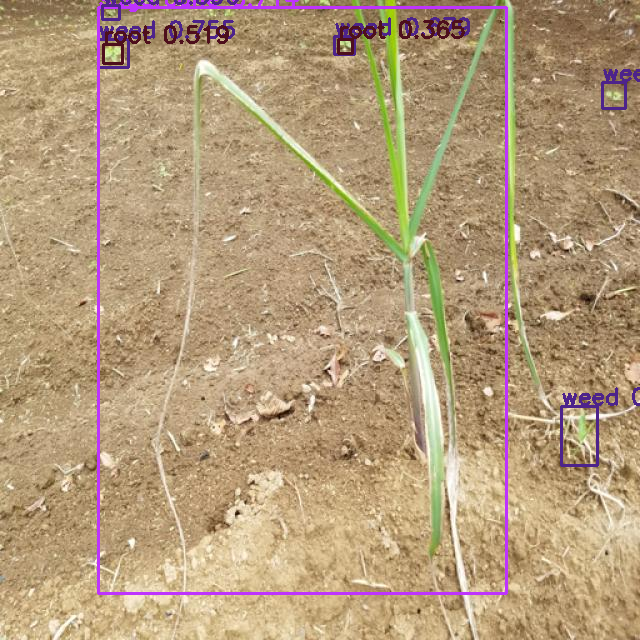

In [ ]:
im = torch.from_numpy(im).to(device)
im/=255
im.shape

# warmup for 10 times
for _ in range(10):
    tmp = torch.randn(1,3,640,640).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

start = time.perf_counter()
binding_addrs['images'] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f'Cost {time.perf_counter()-start} s')

nums = bindings['num_dets'].data
boxes = bindings['det_boxes'].data
scores = bindings['det_scores'].data
classes = bindings['det_classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape

boxes = boxes[0,:nums[0][0]]
scores = scores[0,:nums[0][0]]
classes = classes[0,:nums[0][0]]

for box,score,cl in zip(boxes,scores,classes):
    # print(f"左上頂点:{box[:2]}, 右下頂点{box[2:]}")
    print(f"class: {names[cl]} \n 左上頂点: {box[:2]} \n 右下頂点:{box[2:]} \n")

    box = postprocess(box,ratio,dwdh).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

Image.fromarray(img)

ここから先がjetsonで実装するとき用

In [ ]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
import threading
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [ ]:
TRT_PATH = '/content/drive/MyDrive/sugarcane.trt'
# VIDEO_PATH = ''
device = torch.device('cuda:0')
img = cv2.imread('/content/drive/MyDrive/images/20220905_093539_png.rf.c01e5819d61dd4fe8c7510567ba52ddd.jpg')

# cap = cv2.VideoCapture(0)?
# print(cap.isOpened())

In [ ]:
Binding = namedtuple("Binding", ("name", "dtype", "shape", "data", "ptr"))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")

with open(TRT_PATH, "rb") as f, trt.Runtime(logger) as runtime:
  model = runtime.deserialize_cuda_engine(f.read())

bindings = OrderedDict()
for index in range(model.num_bindings):
  name = model.get_binding_name(index)
  dtype = trt.nptype(model.get_binding_dtype(index))
  shape = tuple(model.get_binding_shape(index))
  data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
  bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

names = ["root", "sugarcane","weed"]

colors = {name:[random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)}

In [ ]:
def letterbox(frame, new_shape=(640, 640), color=(0, 255, 0), auto=True, scaleup=True, stride=32):
  # Resize and pad image while meeting stride-multiple constrains
  shape = frame.shape[:2]
  if isinstance(new_shape, int):
    new_shape = (new_shape, new_shape)

  # Scale ratio (new / old)
  r = min(new_shape[0] / shape[0], new_shape[1], shape[1])
  if not scaleup:
    r = min(r, 1.0)

  # Compute padding
  new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
  dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]

  if auto:
    dw, dh = np.mod(dw, stride), np.mod(dh, stride)

  dw /= 2
  dh /= 2

  if shape[::-1] != new_unpad:
    frame = cv2.resize(frame, new_unpad, interpolation=cv2.INTER_LINEAR)
  top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
  left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
  frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
  return frame, r, (dw, dh)

def postprocess(boxes, r, dwdh):
  dwdh = torch.tensor(dwdh*2).to(boxes.device)
  boxes -= dwdh
  boxes /= r
  return boxes


In [ ]:
def ImageProcessor(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  copy_frame = img.copy()
  copy_frame, ratio, dwdh = letterbox(img, auto=False)
  copy_frame = copy_frame.transpose((2, 0, 1))
  copy_frame = np.expand_dims(copy_frame, 0)
  copy_frame = np.ascontiguousarray(copy_frame)

  copy_frame = copy_frame.astype(np.float32)
  return frame, copy_frame

## main

In [ ]:
while cv2.waitKey(1) != 27:
  hasFrame, frame = cap.read()

  print(hasFrame)
  print(frame)

  if not hasFrame:
    break

  frame, copy_frame = ImageProcessor(frame)
  copy_frme/= 255
  
  # debug
  print(f"copy_frame: {copy_frame.shape}")

  for _ in range(10):
    tmp = torch.randn(1, 3, 640, 640).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_adrs.values()))

  start = time.perf_counter()
  binding_addrs['images'] = int(copy_frame.data_ptr())
  context.execute_v2(list(binding_addrs.values()))
  out = time.perf_counter()

  print(f"Cost: {out - start} s")

  nums = bindings['num_dets'].data
  boxes = bindings['det_boxes'].data
  scores = bindings['det_scores'].data
  classes = bindings['det_classes'].data

  boxes = boxes[0, :nums[0][0]]
  scores = scores[0, :nums[0][0]]
  classes = classes[0, :nums[0][0]]

  for box, score, cl in zip(boxes, scores, classes):
    box = postprocess(box, ratio, dwdh).round().int()
    name = names[cl]
    color = colors[name]
    name += ' '+ str(round(float(score), 3))
    cv2.rectangle(copy_frame, box[:2].tolist(), box[2:].tolist(), color, 2)
    cv2.putText(copy_frame, name, (int(box[0]), int(box[1]) -2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, thickness=2)

  cv2.imshow("capture", frame)


False
None
